<a href="https://colab.research.google.com/github/FacuuC/Proyecto-Segmentacion-de-Clientes/blob/main/SegmentacionClientes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [2]:
# ID del archivo en Google Drive (sacarlo del link compartido)
file_id = "18vZrBY6fQY8HaAS3XihDWNuMn7-1dzYf"
url = f"https://drive.google.com/uc?id={file_id}"

# Cargar CSV directamente
df = pd.read_csv(url)

# Seleccionamos las columnas de interes
df = df[["País", "Monto", "Cantidad"]]


In [3]:
# =====================================================
# 3 - Hacemos limpieza de los datos

df["Monto"] = df["Monto"].str.replace(",", ".", regex=False).astype(float) # Reemplazamos comas por puntos y convertimos a float la columna Monto
df = df[(df["Cantidad"] > 0) & (df["Monto"] > 0)] #Solo seleccionamos los valores positivos (los negativos se pueden interpretar como reembolsos, estaría bueno analizarlos de forma separada)
df = df[df["País"] != "Unspecified"] #Borramos valores de Pais "Unspecified"


In [4]:
# =====================================================
# 4 - Preprocessing

# Definimos los tipos de columnas
var_num = ["Monto","Cantidad"]
var_cat = ["País"]

# Definimos transformadores
numT = RobustScaler()
catT = OneHotEncoder(handle_unknown="ignore")

# Unimos el escalado y el encoding
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numT, var_num),
        ("cat", catT, var_cat),
    ]
)

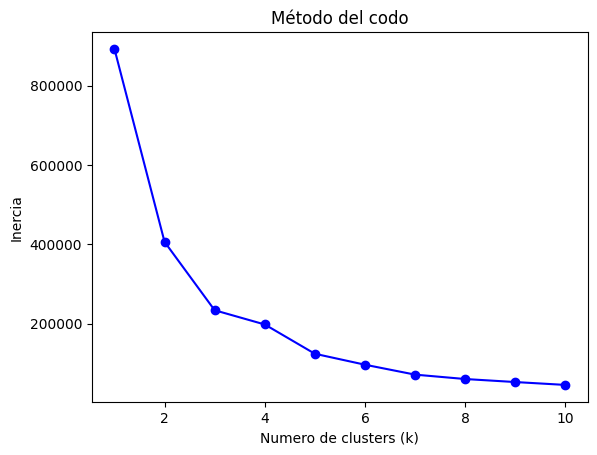

El puntaje para 2 clusters es: 0.9948472947977689
El puntaje para 3 clusters es: 0.9271772870895059
El puntaje para 4 clusters es: 0.9271369209269795
El puntaje para 5 clusters es: 0.861895441563568
El puntaje para 6 clusters es: 0.6861530882023109
El puntaje para 7 clusters es: 0.6776862124492287
El puntaje para 8 clusters es: 0.6171190789672049
El puntaje para 9 clusters es: 0.6152642921748097
El puntaje para 10 clusters es: 0.5575876915731153


In [ ]:
# =====================================================
# 5 - Evaluamos los puntajes de los parametros usados para clustering

# Aplicamos metodo del codo
X = preprocessor.fit_transform(df)
inercia = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inercia.append(kmeans.inertia_)

# Graficamos el metodo del codo
plt.plot(range(1,11), inercia, "bo-")
plt.xlabel("Numero de clusters (k)")
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.show()

# Aplicamos Silhouette score (Opcional)
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score (X, labels)
    print(f"El puntaje para {k} clusters es: {score}")


In [ ]:

# =====================================================
# 6 - Clustering

# En base a los valores obtenidos, definimos la cantidad de clusteres para el clustering
k_optimo = 3

# Creamos el pipeline con KMeans
pipeline = Pipeline(steps=[
    ("preprocessor",preprocessor),
    ("cluster", KMeans(n_clusters=k_optimo, random_state=42))
])

# Entrenamos el modelo
pipeline.fit(df)

# Obtenemos las etiquetas de los clusters
df["Cluster"] = pipeline["cluster"].labels_


In [ ]:
# =====================================================
# 7 - Sacamos las estadisticas para realizar conclusiones de valor

cluster_counts = df['Cluster'].value_counts()

# Cantidad de filas por cluster
print("Cantidad de filas por cluster: \n", cluster_counts , "\n")

# Media de cada cluster para columna Monto
cluster_summary_Mount = df.groupby("Cluster")[["Monto"]].describe()
print(f"Promedios de la columna Monto por clusters: \n{cluster_summary_Mount}\n\n")

# Media de cada cluster para columna Cantidad
cluster_summary_Count = df.groupby("Cluster")[["Cantidad"]].describe()
print(f"Promedios de la columna Cantidad por clusters: \n{cluster_summary_Count}\n\n")

# Paises más frecuentes en cada cluster
top_paises = df.groupby("Cluster")["País"].value_counts().groupby(level=0).head(5)
print("\nTop 5 países por cada cluster:")
print(top_paises)

# Mostramos las primeras filas del cluster elegido
"""cluster_id = 0
df_cluster = df[df["Cluster"] == cluster_id]
print(f"Se muestran las primeras filas del cluster {cluster_id}: \n", df_cluster.head())"""


Cantidad de filas por cluster: 
 Cluster
0    19797
2      193
1        2
Name: count, dtype: int64 

Promedios de la columna Monto por clusters: 
           Monto                                                               \
           count           mean           std       min        25%        50%   
Cluster                                                                         
0        19797.0     438.214724    560.277906      0.38     150.90     302.56   
1            2.0  122826.600000  64548.949627  77183.60  100005.10  122826.60   
2          193.0    9029.620052   6711.236798   2016.00    5433.57    7138.12   

                               
               75%        max  
Cluster                        
0           484.86    6068.06  
1        145648.10  168469.60  
2         10303.95   52940.94  


Promedios de la columna Cantidad por clusters: 
        Cantidad                                                        \
           count          mean          std      m

In [ ]:
# Agrupar por cluster y país, contar apariciones
cluster_paises = df.groupby(["Cluster", "País"]).size().reset_index(name="Cantidad")

# Calcular porcentaje dentro de cada cluster (usando transform para evitar error de índices)
cluster_paises["Porcentaje"] = (
    cluster_paises["Cantidad"] /
    cluster_paises.groupby("Cluster")["Cantidad"].transform("sum") * 100
)

# Ordenar dentro de cada cluster
cluster_paises = cluster_paises.sort_values(["Cluster", "Cantidad"], ascending=[True, False])

# Tomar los 5 países principales de cada cluster
top5_por_cluster = cluster_paises.groupby("Cluster").head(5)

# (Opcional) redondear porcentajes para que quede más presentable
top5_por_cluster["Porcentaje"] = top5_por_cluster["Porcentaje"].round(2)

# Mostrar tabla
print(top5_por_cluster)

    Cluster            País  Cantidad  Porcentaje
36        0  United Kingdom     17918       90.51
14        0         Germany       456        2.30
13        0          France       391        1.98
10        0            EIRE       283        1.43
3         0         Belgium        98        0.50
37        1  United Kingdom         2      100.00
47        2  United Kingdom       140       72.54
44        2     Netherlands        24       12.44
38        2       Australia         9        4.66
39        2            EIRE         7        3.63
43        2           Japan         3        1.55


/tmp/ipython-input-1203000629.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top5_por_cluster["Porcentaje"] = top5_por_cluster["Porcentaje"].round(2)


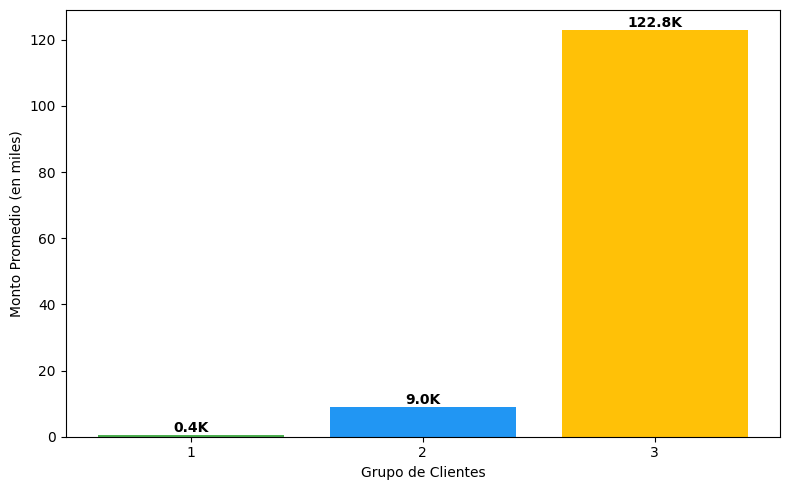

In [ ]:
# Grafico de barras representativo del monto promedio por cada cluster, en miles de libras esterlinas
promedios = df.groupby("Cluster")["Monto"].mean()
orden_clusters = [0, 2, 1]
promedios = promedios.reindex(orden_clusters)

nombres_grupos = ["1","2","3"]
promedio_miles = promedios/1000

# Crear gráfico de barras
plt.figure(figsize=(8,5))
bars=plt.bar(nombres_grupos, promedio_miles.values, color=['#4CAF50','#2196F3','#FFC107'])

# Agregar valores encima de cada barra
for bar, valor in zip(bars, promedio_miles.values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f"{valor:,.1f}K",  # Formato con 1 decimal y 'K' de miles
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.xlabel("Grupo de Clientes")
plt.ylabel("Monto Promedio (en miles)")
plt.tight_layout()
plt.show()

/tmp/ipython-input-3532099874.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pais_por_grupo = pais_por_grupo.groupby("Cluster").apply(lambda x: x.nlargest(5, "Cantidad")).reset_index(drop=True)


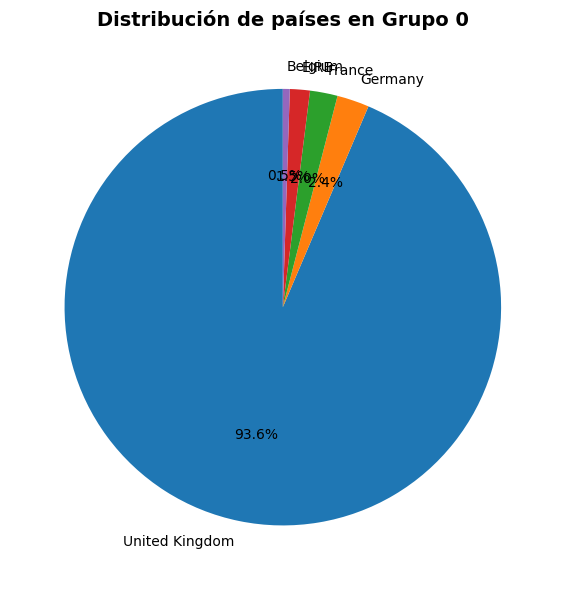

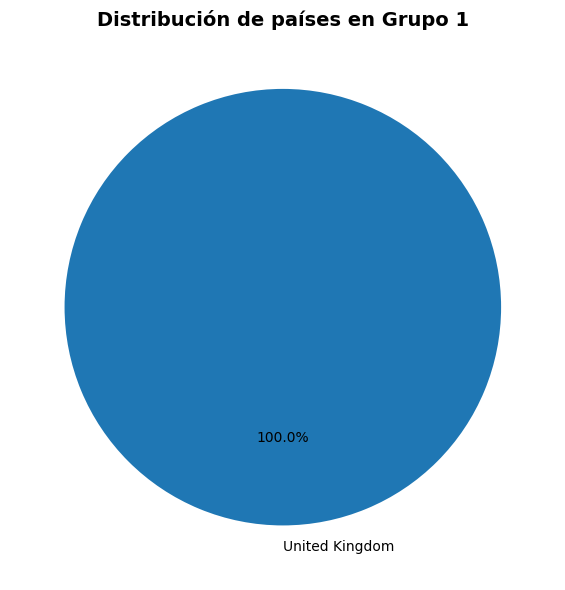

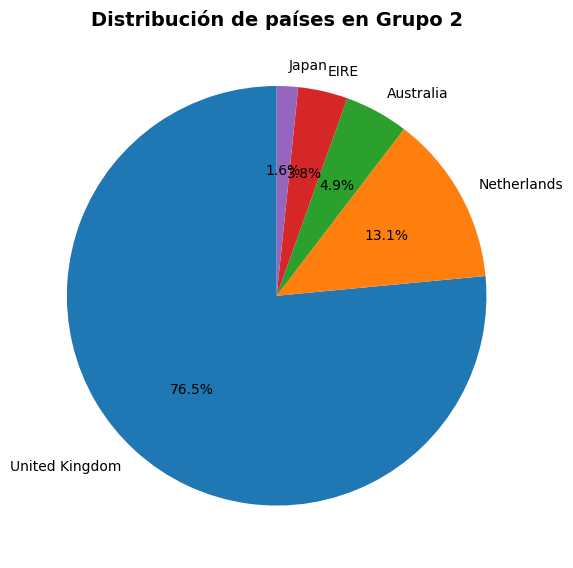

In [ ]:
# Agrupar por Cluster y País para contar ocurrencias
pais_por_grupo = df.groupby(["Cluster", "País"]).size().reset_index(name="Cantidad")
pais_por_grupo = pais_por_grupo.groupby("Cluster").apply(lambda x: x.nlargest(5, "Cantidad")).reset_index(drop=True)

# Generar un gráfico de torta para cada grupo
for cluster in pais_por_grupo["Cluster"].unique():
    datos_cluster = pais_por_grupo[pais_por_grupo["Cluster"] == cluster]
    plt.figure(figsize=(6,6))
    plt.pie(
        datos_cluster["Cantidad"],
        labels=datos_cluster["País"],
        autopct="%1.1f%%",
        startangle=90
    )
    plt.title(f"Distribución de países en Grupo {cluster}", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

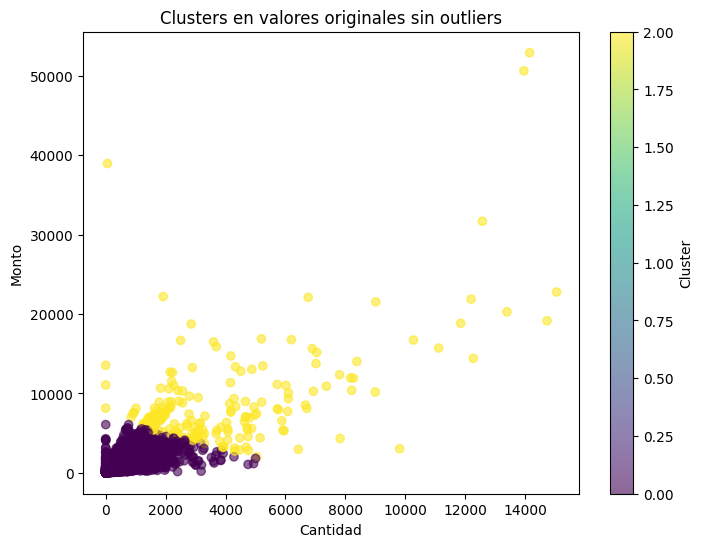

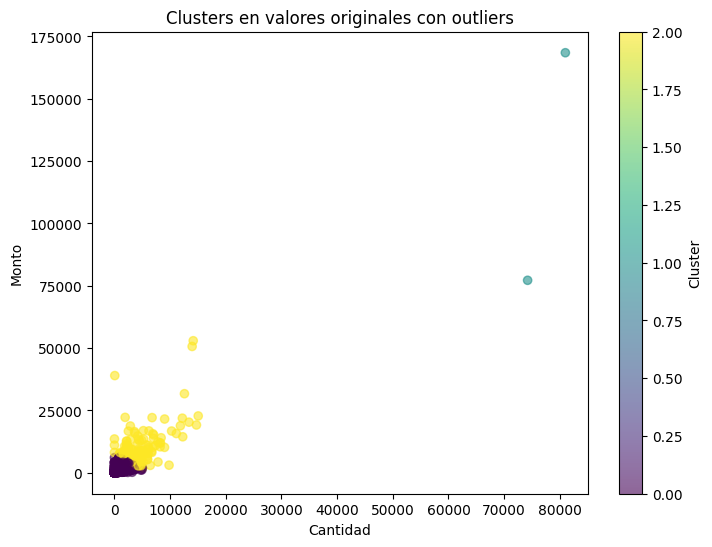

In [ ]:
# Visualizacion de compras agrupadas por clusters sin outliers
df_filtrado = df[df["Cluster"] != 1]

plt.figure(figsize=(8,6))
plt.scatter(df_filtrado["Cantidad"],df_filtrado["Monto"],
            c=df_filtrado["Cluster"], cmap="viridis", alpha=0.6)

plt.xlabel("Cantidad")
plt.ylabel("Monto")
plt.title("Clusters en valores originales sin outliers")
plt.colorbar(label="Cluster")

# Visualizacion de compras agrupadas por clusters con outliers
plt.figure(figsize=(8,6))
plt.scatter(df["Cantidad"],df["Monto"],
            c=df["Cluster"], cmap="viridis", alpha=0.6)

plt.xlabel("Cantidad")
plt.ylabel("Monto")
plt.title("Clusters en valores originales con outliers")
plt.colorbar(label="Cluster")

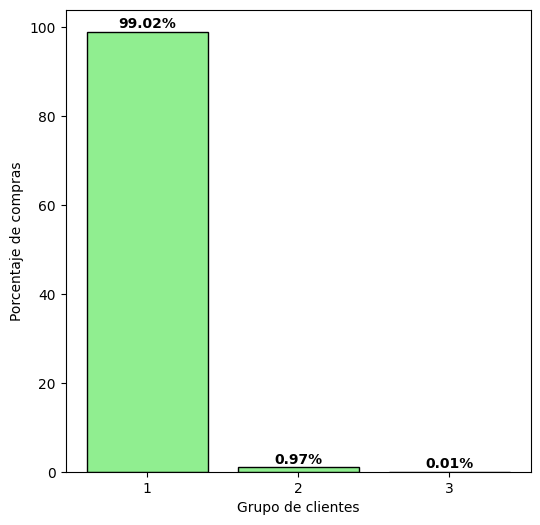

In [ ]:
# Mostrar porcentajes de compras por grupro
# Mapear clusters originales a etiquetas 1, 2, 3
cluster_map = {0: 1, 2: 2, 1: 3}
df["ClusterRenombrado"] = df["Cluster"].map(cluster_map)

# Contar compras (filas) por grupo
compras_por_grupo = df["ClusterRenombrado"].value_counts().sort_index()

# Calcular porcentajes
porcentajes = compras_por_grupo / compras_por_grupo.sum() * 100

# Graficar histograma de barras
plt.figure(figsize=(6,6))
bars = plt.bar(porcentajes.index, porcentajes.values,
                color="lightgreen", edgecolor="black")

plt.xlabel("Grupo de clientes")
plt.ylabel("Porcentaje de compras")
plt.xticks([1, 2, 3])

# Agregar etiquetas de cantidad arriba de cada barra
for bar, pct in zip(bars, porcentajes.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f"{pct:.2f}%", ha='center', va='bottom', fontsize=10, fontweight="bold")
plt.show()

In [ ]:
# =====================================================
# 8 - Guardo en un csv el dataframe resultante con las filas etiquetadas con los clusters correspondientes (de menor cantidad de filas por cluster a mayor)

# Crear un diccionario que mapea cada cluster a su cantidad de filas
cluster_size_map = cluster_counts.to_dict()

# Crear una columna temporal con el tamaño del cluster de cada fila
df['cluster_size'] = df['Cluster'].map(cluster_size_map)

# Ordenar por esa columna (de menor a mayor)
df_sorted = df.sort_values('cluster_size')
df_sorted = df_sorted.drop(columns=['cluster_size'])

# 4. Guardar en CSV
df_sorted.to_csv('df_ordenado_porCluster.csv', index=False)